In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import image
from nilearn import plotting

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# load the data 

In [3]:
path_data = '/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/'

In [80]:
# load adni csv
adni1_df = pd.read_csv(path_data + '7clus/adni1_model_weights.csv')
adni2_df = pd.read_csv(path_data + '7clus/adni2_model_weights.csv')
adni1_mci = pd.read_csv(path_data + '7clus/adni1_mci_filter_model_weights.csv')
adni2_mci = pd.read_csv(path_data + '7clus/adni2_mci_filter_model_weights.csv')

In [81]:
adni1_df.set_index('RID',inplace=True)
adni2_df.set_index('RID',inplace=True)
adni1_mci.set_index('RID',inplace=True)
adni2_mci.set_index('RID',inplace=True)

In [82]:
# get rid of duplicates from ADNI1 in ADNI2 
adni2_df = adni2_df.loc[set(adni2_df.index)-set(adni1_df.index)]

In [83]:
# get just ad & cn subjects
adni1_adcn = adni1_df.loc[set(adni1_df.index)-set(adni1_mci.index)]
adni2_adcn = adni2_df.loc[set(adni2_df.index)-set(adni2_mci.index)]

In [85]:
frames = [adni1_adcn, adni1_mci, adni2_adcn, adni2_mci]
adni_df = pd.concat(frames)

In [86]:
adni_df.reset_index(inplace=True)

In [87]:
# add categorical variable for diagnosis
for i,row in adni_df.iterrows():
    cn = row[adni_df.columns.get_loc("CN")]
    mci = row[adni_df.columns.get_loc("MCI")]
    ad = row[adni_df.columns.get_loc("AD")]
    conv_2_ad = row[adni_df.columns.get_loc("conv_2_ad")]
    if cn == 1:
        adni_df.ix[i,'diagnosis'] = 'CN'
        adni_df.ix[i,'sMCI'] = 0
        adni_df.ix[i,'pMCI'] = 0
    if mci == 1 and conv_2_ad == 0:
        adni_df.ix[i,'diagnosis'] = 'sMCI'
        adni_df.ix[i,'sMCI'] = 1
        adni_df.ix[i,'pMCI'] = 0
    if mci == 1 and conv_2_ad == 1:
        adni_df.ix[i,'diagnosis'] = 'pMCI'
        adni_df.ix[i,'sMCI'] = 0
        adni_df.ix[i,'pMCI'] = 1
    if ad == 1:
        adni_df.ix[i,'diagnosis'] = 'AD'
        adni_df.ix[i,'sMCI'] = 0
        adni_df.ix[i,'pMCI'] = 0

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [88]:
# get rid of NaNs 
adni_df.dropna(axis=0, how='any', subset=['diagnosis','age_scan','mean_gm','tiv','APOE4_bin','sub1'],inplace=True)

In [4]:
# load subtype nifti
sub_img = image.load_img(path_data + '7clus/mean_subtype.nii')

In [9]:
n_list = [1,2,3,4,5,6,7]
for n_sub in n_list:
    sub_vol = image.index_img(sub_img, n_sub-1)
    plotting.plot_stat_map(sub_vol,vmax=0.1,
                           output_file=path_data + '7clus/mean_subtype_%s.png'%n_sub)

In [5]:
image.index_img?

In [90]:
def get_subtype_results(sub_img, n_sub, adni_df):
    print('Running analyses for subtype %s ....'%n_sub)
    
    # load volume
    sub_vol = image.index_img(sub_img, n_sub-1)
    plotting.plot_stat_map(sub_vol,display_mode="z",cut_coords=(-43,-31,-21,-10,0,31,42,54,63),vmax=0.1)
    plotting.show()

    # weight distributions
    sns.set_palette("colorblind",4)
    sns.distplot(adni_df[adni_df.CN==1]['sub%s'%n_sub].values,10,label='CN', kde=False)
    sns.distplot(adni_df[adni_df.sMCI==1]['sub%s'%n_sub].values,10,label='sMCI', kde=False)
    sns.distplot(adni_df[adni_df.pMCI==1]['sub%s'%n_sub].values,10,label='pMCI', kde=False)
    sns.distplot(adni_df[adni_df.AD==1]['sub%s'%n_sub].values,10,label='AD', kde=False)
    plt.legend(loc='upper right')
    plt.ylim(0,120)
    plt.ylabel('# subjects')
    plt.xlabel('weight')
    plt.show()

    ##################### GLM on ADNI dx groups
    # full model with dx
    print('############################################################')
    print('GLM results for effect of diagnosis on subtype weight')
    print('############################################################')
    f_model = smf.ols('sub%s ~ mean_gm + tiv + age_scan + gender + AD + sMCI + pMCI'%n_sub, data=adni_df).fit()
    # reduced model without dx
    r_model = smf.ols('sub%s ~ mean_gm + tiv + age_scan + gender'%n_sub, data=adni_df).fit()
    # add residuals to dataframe
    adni_df['sub%s_resid'%n_sub] = r_model.resid

    # boxplot of weights across ADNI diagnosis
    x_order = ['CN','sMCI','pMCI','AD']
    sns.boxplot(x="diagnosis", y="sub%s_resid"%n_sub, data=adni_df, fliersize=0, order=x_order)
    sns.swarmplot(x="diagnosis",y="sub%s_resid"%n_sub,data=adni_df, color="0.25", size=3, order=x_order)
    plt.show()

    # pairwise post hoc ttests
    mod = sm.stats.multicomp.MultiComparison(adni_df['sub%s'%n_sub],adni_df['diagnosis'])
    pval = mod.allpairtest(stats.ttest_ind, method='bonf')
    print(f_model.summary())
    print('############################################################')
    print('F test on full and reduced model:')
    print('############################################################')
    print(sm.stats.anova_lm(r_model,f_model,test='F'))
    print('############################################################')
    print('Pairwise post hoc t-tests between groups')
    print('############################################################')
    print(mod.tukeyhsd())
    print(pval[0])

    ############################# GLM on APOE4 in ADNI
    print('############################################################')
    print('GLM results for effect of APOE4')
    print('############################################################')
    f_model = smf.ols('sub%s ~ mean_gm + tiv + age_scan + gender + APOE4_bin'%n_sub, data=adni_df).fit()
    # reduced model without dx
    r_model = smf.ols('sub%s ~ mean_gm + tiv + age_scan + gender'%n_sub, data=adni_df).fit()
    # pairwise post hoc ttests
    mod = sm.stats.multicomp.MultiComparison(adni_df['sub%s'%n_sub],adni_df['APOE4_bin'])
    pval = mod.allpairtest(stats.ttest_ind, method='bonf')
    # plot
    sns.boxplot(x="APOE4_bin",y='sub%s_resid'%n_sub,data=adni_df,fliersize=0)
    sns.swarmplot(x="APOE4_bin",y="sub%s_resid"%n_sub,data=adni_df,color="0.25",size=3)
    plt.show()
    print(f_model.summary())
    print('############################################################')
    print('Pairwise post hoc t-tests between groups')
    print('############################################################')
    print(mod.tukeyhsd())
    print(pval[0])

    ############################# GLM on ADNI AV45
    # full model with subtype
    print('############################################################')
    print('GLM results for effect of subtype weight on amyloid (AV45)')
    print('############################################################')
    f_model = smf.ols('AV45 ~ sub%s + mean_gm + tiv + age_scan + gender + AD + sMCI + pMCI'%n_sub, data=adni_df).fit()
    # reduced model without subtype
    r_model = smf.ols('AV45 ~ mean_gm + tiv + age_scan + gender + AD + sMCI + pMCI', data=adni_df).fit()
    # plot
    adni_df['av45_resid'] = r_model.resid
    sns.regplot(x="sub%s"%n_sub,y="av45_resid",data=adni_df)
    plt.show()
    print(f_model.summary())
    print('############################################################')
    print('F test on full and reduced model:')
    print('############################################################')
    print(sm.stats.anova_lm(r_model,f_model,test='F'))
    
    ############################# GLM on ADNI CSF ABETA
    # full model with subtype
    print('############################################################')
    print('GLM results for effect of subtype weight on amyloid (CSF)')
    print('############################################################')
    f_model = smf.ols('ABETA ~ sub%s + mean_gm + tiv + age_scan + gender + AD + sMCI + pMCI'%n_sub, data=adni_df).fit()
    # reduced model without subtype
    r_model = smf.ols('ABETA ~ mean_gm + tiv + age_scan + gender + AD + sMCI + pMCI', data=adni_df).fit()
    # plot
    adni_df['abeta_resid'] = r_model.resid
    sns.regplot(x="sub%s"%n_sub,y="abeta_resid",data=adni_df)
    plt.show()
    print(f_model.summary())
    print('############################################################')
    print('F test on full and reduced model:')
    print('############################################################')
    print(sm.stats.anova_lm(r_model,f_model,test='F'))
    
    ############################# GLM on ADNI CSF tau
    # full model with subtype
    print('############################################################')
    print('GLM results for effect of subtype weight on tau (CSF)')
    print('############################################################')
    f_model = smf.ols('TAU ~ sub%s + mean_gm + tiv + age_scan + gender + AD + sMCI + pMCI'%n_sub, data=adni_df).fit()
    # reduced model without subtype
    r_model = smf.ols('TAU ~ mean_gm + tiv + age_scan + gender + AD + sMCI + pMCI', data=adni_df).fit()
    # plot
    adni_df['tau_resid'] = r_model.resid
    sns.regplot(x="sub%s"%n_sub,y="tau_resid",data=adni_df)
    plt.show()
    print(f_model.summary())
    print('############################################################')
    print('F test on full and reduced model:')
    print('############################################################')
    print(sm.stats.anova_lm(r_model,f_model,test='F'))

    ############################## GLM on MMSE
    # full model with subtype
    print('############################################################')
    print('GLM results for effect of subtype weight on MMSE')
    print('############################################################')
    f_model = smf.ols('MMSE_bl ~ sub%s + mean_gm + tiv + age_scan + gender '%n_sub, data=adni_df).fit()
    r_model = smf.ols('MMSE_bl ~ mean_gm + tiv + age_scan + gender ', data=adni_df).fit()
    # plot
    adni_df['MMSE_resid'] = r_model.resid
    sns.regplot(x='sub%s'%n_sub,y='MMSE_resid',data=adni_df)
    plt.show()
    print(f_model.summary())
    print('############################################################')
    print('F test on full and reduced model:')
    print('############################################################')
    print(sm.stats.anova_lm(r_model,f_model,test='F'))

# subtype 1 

Running analyses for subtype 1 ....


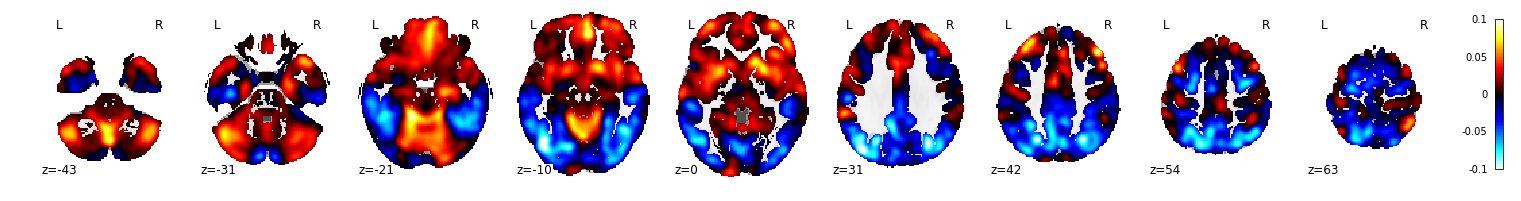

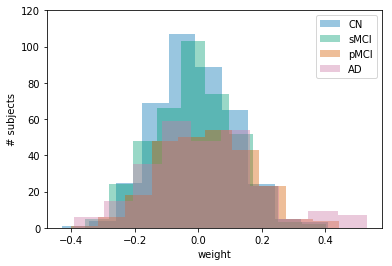

############################################################
GLM results for effect of diagnosis on subtype weight
############################################################


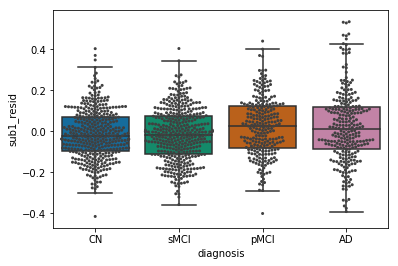

                            OLS Regression Results                            
Dep. Variable:                   sub1   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.784
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           0.000450
Time:                        20:09:25   Log-Likelihood:                 718.20
No. Observations:                1305   AIC:                            -1420.
Df Residuals:                    1297   BIC:                            -1379.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1433      0.082     -1.757      0.0

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


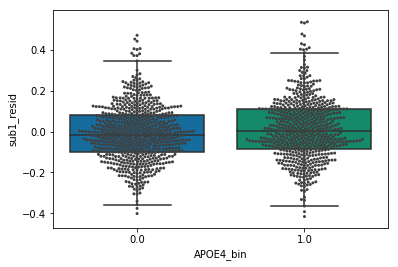

                            OLS Regression Results                            
Dep. Variable:                   sub1   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.400
Date:                Sun, 10 Dec 2017   Prob (F-statistic):              0.221
Time:                        20:09:28   Log-Likelihood:                 708.51
No. Observations:                1305   AIC:                            -1405.
Df Residuals:                    1299   BIC:                            -1374.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0915      0.081     -1.135      0.2

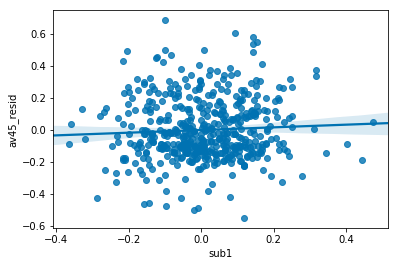

                            OLS Regression Results                            
Dep. Variable:                   AV45   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     25.58
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           4.58e-33
Time:                        20:09:29   Log-Likelihood:                 117.51
No. Observations:                 501   AIC:                            -217.0
Df Residuals:                     492   BIC:                            -179.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8556      0.209      4.093      0.0

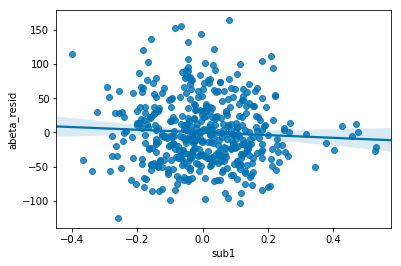

                            OLS Regression Results                            
Dep. Variable:                  ABETA   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     17.99
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           1.87e-23
Time:                        20:09:30   Log-Likelihood:                -2487.6
No. Observations:                 470   AIC:                             4993.
Df Residuals:                     461   BIC:                             5031.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    228.0049     45.328      5.030      0.0

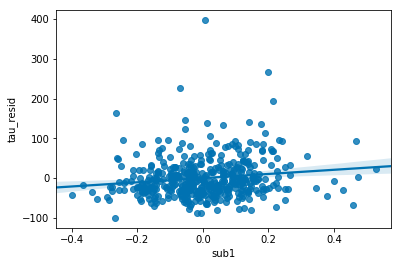

                            OLS Regression Results                            
Dep. Variable:                    TAU   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     14.12
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           2.19e-18
Time:                        20:09:31   Log-Likelihood:                -2435.3
No. Observations:                 457   AIC:                             4889.
Df Residuals:                     448   BIC:                             4926.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.4324     47.474      0.831      0.4

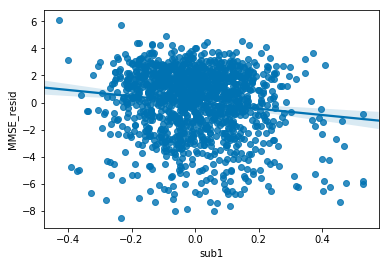

                            OLS Regression Results                            
Dep. Variable:                MMSE_bl   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     40.80
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           4.53e-39
Time:                        20:09:32   Log-Likelihood:                -3036.7
No. Observations:                1305   AIC:                             6085.
Df Residuals:                    1299   BIC:                             6117.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.4949      1.412     15.219      0.0

In [91]:
get_subtype_results(sub_img, 1, adni_df)

# subtype 2

Running analyses for subtype 2 ....


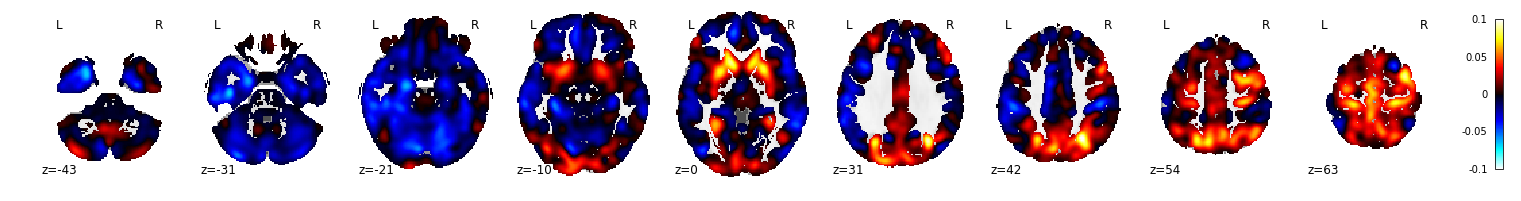

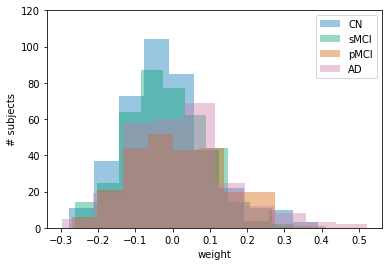

############################################################
GLM results for effect of diagnosis on subtype weight
############################################################


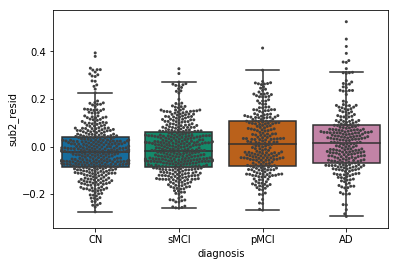

                            OLS Regression Results                            
Dep. Variable:                   sub2   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     4.466
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           6.34e-05
Time:                        20:09:38   Log-Likelihood:                 925.57
No. Observations:                1305   AIC:                            -1835.
Df Residuals:                    1297   BIC:                            -1794.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0577      0.070     -0.829      0.4

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


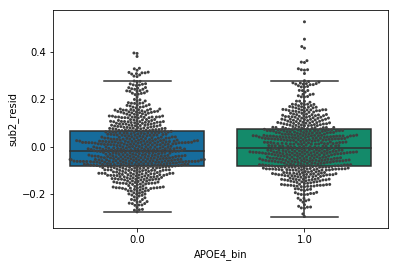

                            OLS Regression Results                            
Dep. Variable:                   sub2   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4266
Date:                Sun, 10 Dec 2017   Prob (F-statistic):              0.830
Time:                        20:09:41   Log-Likelihood:                 911.10
No. Observations:                1305   AIC:                            -1810.
Df Residuals:                    1299   BIC:                            -1779.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0095      0.069      0.138      0.8

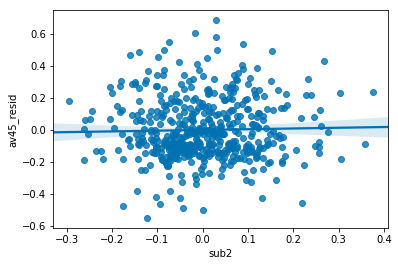

                            OLS Regression Results                            
Dep. Variable:                   AV45   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     25.37
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           8.34e-33
Time:                        20:09:42   Log-Likelihood:                 116.89
No. Observations:                 501   AIC:                            -215.8
Df Residuals:                     492   BIC:                            -177.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8434      0.209      4.032      0.0

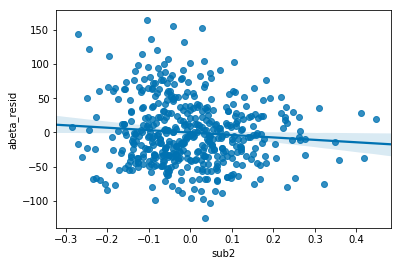

                            OLS Regression Results                            
Dep. Variable:                  ABETA   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     18.32
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           7.04e-24
Time:                        20:09:43   Log-Likelihood:                -2486.6
No. Observations:                 470   AIC:                             4991.
Df Residuals:                     461   BIC:                             5029.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    234.6579     45.193      5.192      0.0

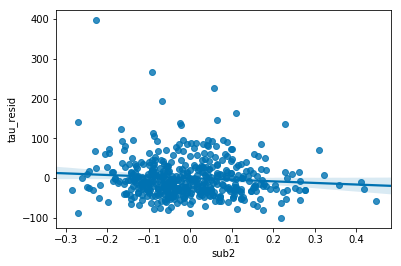

                            OLS Regression Results                            
Dep. Variable:                    TAU   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     13.20
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           3.64e-17
Time:                        20:09:45   Log-Likelihood:                -2438.3
No. Observations:                 457   AIC:                             4895.
Df Residuals:                     448   BIC:                             4932.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.8173     47.770      0.750      0.4

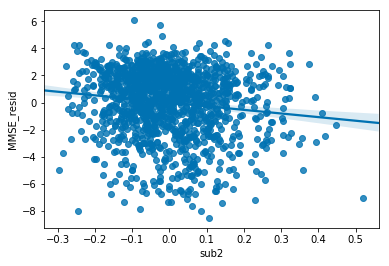

                            OLS Regression Results                            
Dep. Variable:                MMSE_bl   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     40.69
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           5.72e-39
Time:                        20:09:46   Log-Likelihood:                -3037.0
No. Observations:                1305   AIC:                             6086.
Df Residuals:                    1299   BIC:                             6117.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.7079      1.412     15.371      0.0

In [92]:
get_subtype_results(sub_img, 2, adni_df)

# subtype 3 

Running analyses for subtype 3 ....


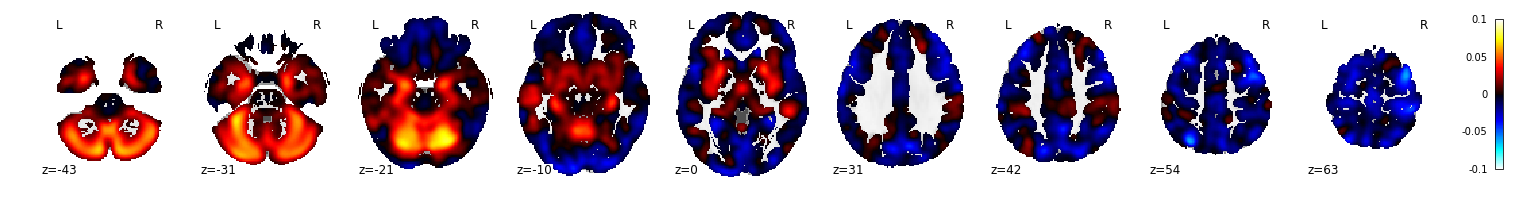

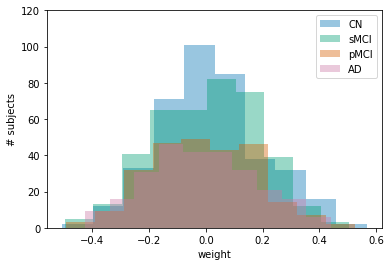

############################################################
GLM results for effect of diagnosis on subtype weight
############################################################


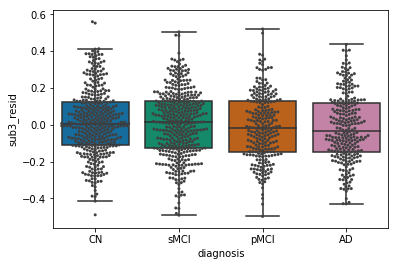

                            OLS Regression Results                            
Dep. Variable:                   sub3   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.098
Date:                Sun, 10 Dec 2017   Prob (F-statistic):              0.362
Time:                        20:09:53   Log-Likelihood:                 379.69
No. Observations:                1305   AIC:                            -743.4
Df Residuals:                    1297   BIC:                            -702.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0178      0.106     -0.168      0.8

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


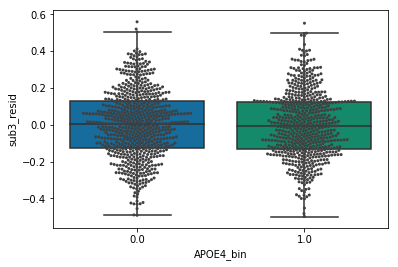

                            OLS Regression Results                            
Dep. Variable:                   sub3   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1784
Date:                Sun, 10 Dec 2017   Prob (F-statistic):              0.971
Time:                        20:09:56   Log-Likelihood:                 376.29
No. Observations:                1305   AIC:                            -740.6
Df Residuals:                    1299   BIC:                            -709.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0741      0.104     -0.713      0.4

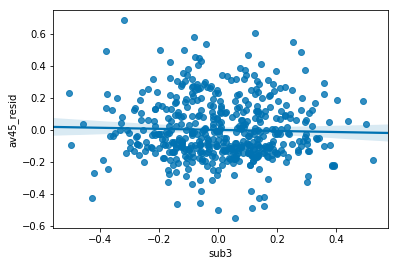

                            OLS Regression Results                            
Dep. Variable:                   AV45   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     25.39
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           7.74e-33
Time:                        20:09:57   Log-Likelihood:                 116.96
No. Observations:                 501   AIC:                            -215.9
Df Residuals:                     492   BIC:                            -178.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8411      0.209      4.020      0.0

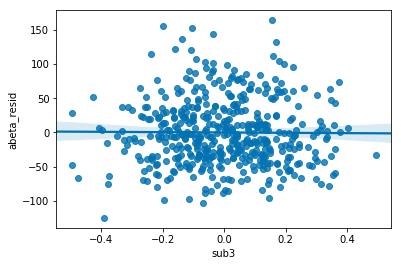

                            OLS Regression Results                            
Dep. Variable:                  ABETA   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     17.73
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           3.99e-23
Time:                        20:09:58   Log-Likelihood:                -2488.4
No. Observations:                 470   AIC:                             4995.
Df Residuals:                     461   BIC:                             5032.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    231.2915     45.337      5.102      0.0

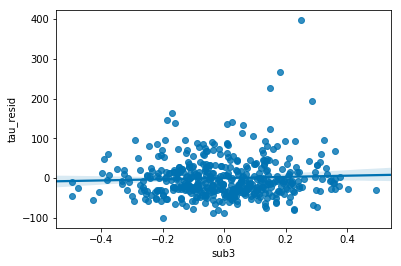

                            OLS Regression Results                            
Dep. Variable:                    TAU   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     12.75
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           1.43e-16
Time:                        20:09:58   Log-Likelihood:                -2439.8
No. Observations:                 457   AIC:                             4898.
Df Residuals:                     448   BIC:                             4935.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.3384     47.884      0.654      0.5

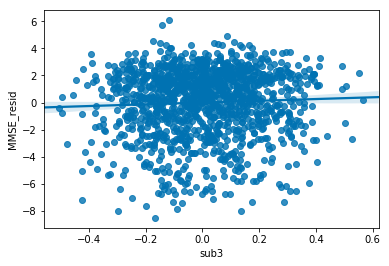

                            OLS Regression Results                            
Dep. Variable:                MMSE_bl   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     36.34
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           6.36e-35
Time:                        20:09:59   Log-Likelihood:                -3046.5
No. Observations:                1305   AIC:                             6105.
Df Residuals:                    1299   BIC:                             6136.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.7032      1.423     15.254      0.0

In [93]:
get_subtype_results(sub_img, 3, adni_df)

# subtype 4

Running analyses for subtype 4 ....


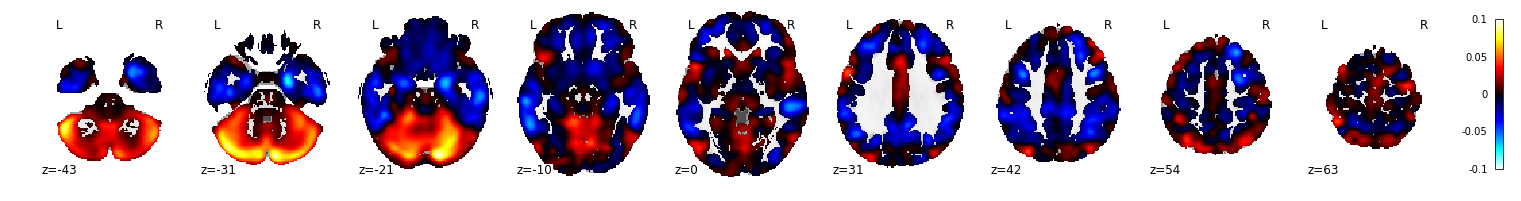

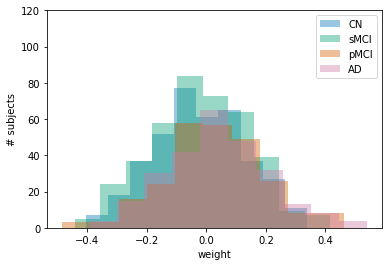

############################################################
GLM results for effect of diagnosis on subtype weight
############################################################


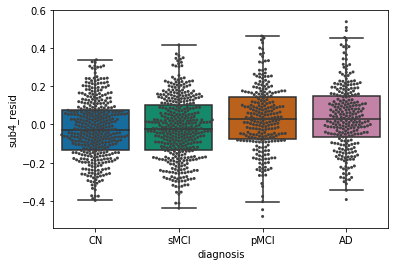

                            OLS Regression Results                            
Dep. Variable:                   sub4   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     6.291
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           2.80e-07
Time:                        20:10:05   Log-Likelihood:                 528.78
No. Observations:                1305   AIC:                            -1042.
Df Residuals:                    1297   BIC:                            -1000.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1662      0.094     -1.762      0.0

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


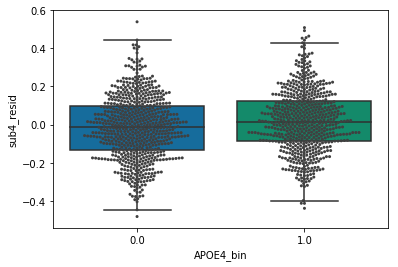

                            OLS Regression Results                            
Dep. Variable:                   sub4   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.042
Date:                Sun, 10 Dec 2017   Prob (F-statistic):            0.00979
Time:                        20:10:08   Log-Likelihood:                 514.58
No. Observations:                1305   AIC:                            -1017.
Df Residuals:                    1299   BIC:                            -986.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0862      0.094     -0.922      0.3

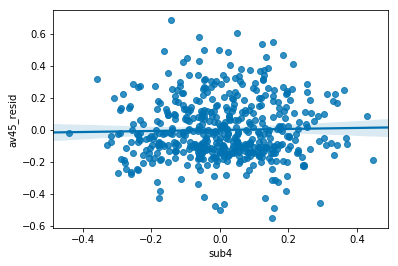

                            OLS Regression Results                            
Dep. Variable:                   AV45   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     25.37
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           8.33e-33
Time:                        20:10:09   Log-Likelihood:                 116.89
No. Observations:                 501   AIC:                            -215.8
Df Residuals:                     492   BIC:                            -177.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8481      0.209      4.054      0.0

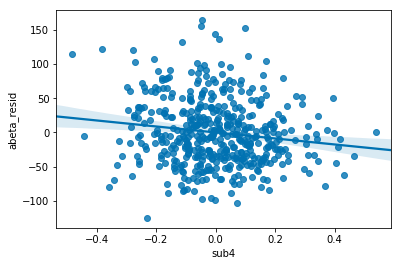

                            OLS Regression Results                            
Dep. Variable:                  ABETA   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     19.38
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           3.33e-25
Time:                        20:10:09   Log-Likelihood:                -2483.3
No. Observations:                 470   AIC:                             4985.
Df Residuals:                     461   BIC:                             5022.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    230.2816     44.848      5.135      0.0

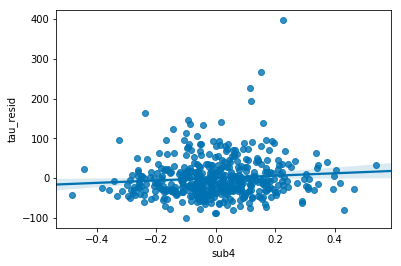

                            OLS Regression Results                            
Dep. Variable:                    TAU   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     13.21
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           3.58e-17
Time:                        20:10:10   Log-Likelihood:                -2438.3
No. Observations:                 457   AIC:                             4895.
Df Residuals:                     448   BIC:                             4932.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.1550     47.731      0.695      0.4

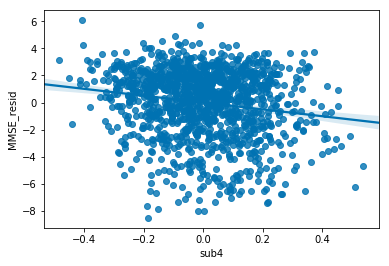

                            OLS Regression Results                            
Dep. Variable:                MMSE_bl   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     44.03
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           4.83e-42
Time:                        20:10:11   Log-Likelihood:                -3029.8
No. Observations:                1305   AIC:                             6072.
Df Residuals:                    1299   BIC:                             6103.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.5405      1.405     15.336      0.0

In [94]:
get_subtype_results(sub_img, 4, adni_df)

# subtype 5

Running analyses for subtype 5 ....


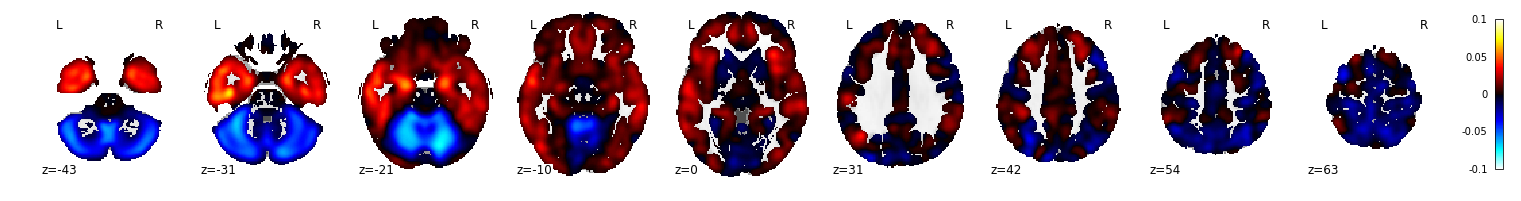

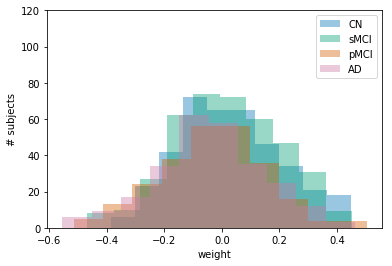

############################################################
GLM results for effect of diagnosis on subtype weight
############################################################


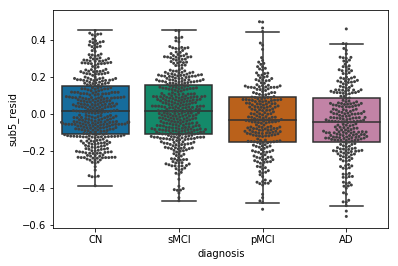

                            OLS Regression Results                            
Dep. Variable:                   sub5   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     6.017
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           6.41e-07
Time:                        20:10:18   Log-Likelihood:                 376.60
No. Observations:                1305   AIC:                            -737.2
Df Residuals:                    1297   BIC:                            -695.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1909      0.106      1.802      0.0

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


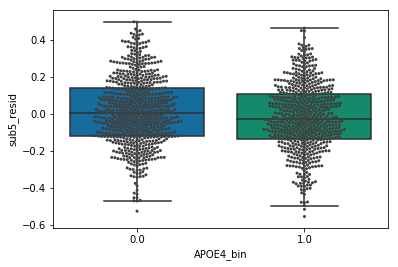

                            OLS Regression Results                            
Dep. Variable:                   sub5   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.318
Date:                Sun, 10 Dec 2017   Prob (F-statistic):             0.0414
Time:                        20:10:20   Log-Likelihood:                 361.54
No. Observations:                1305   AIC:                            -711.1
Df Residuals:                    1299   BIC:                            -680.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0957      0.105      0.910      0.3

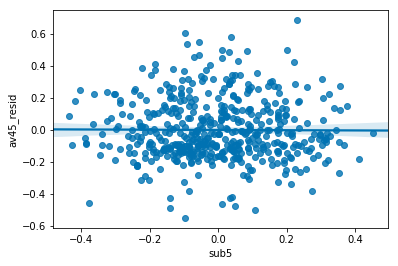

                            OLS Regression Results                            
Dep. Variable:                   AV45   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     25.31
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           9.64e-33
Time:                        20:10:21   Log-Likelihood:                 116.73
No. Observations:                 501   AIC:                            -215.5
Df Residuals:                     492   BIC:                            -177.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8462      0.209      4.045      0.0

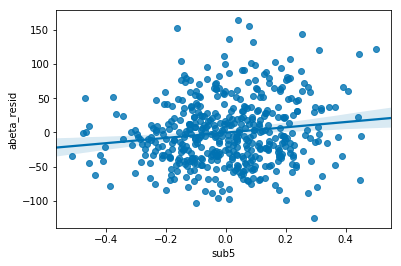

                            OLS Regression Results                            
Dep. Variable:                  ABETA   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     19.33
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           3.77e-25
Time:                        20:10:22   Log-Likelihood:                -2483.5
No. Observations:                 470   AIC:                             4985.
Df Residuals:                     461   BIC:                             5022.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    232.3526     44.861      5.179      0.0

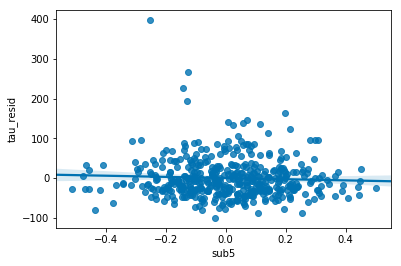

                            OLS Regression Results                            
Dep. Variable:                    TAU   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     12.76
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           1.40e-16
Time:                        20:10:23   Log-Likelihood:                -2439.8
No. Observations:                 457   AIC:                             4898.
Df Residuals:                     448   BIC:                             4935.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.6444     47.880      0.661      0.5

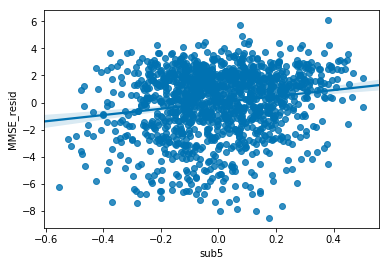

                            OLS Regression Results                            
Dep. Variable:                MMSE_bl   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     44.46
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           1.94e-42
Time:                        20:10:24   Log-Likelihood:                -3028.8
No. Observations:                1305   AIC:                             6070.
Df Residuals:                    1299   BIC:                             6101.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.5259      1.404     15.337      0.0

In [95]:
get_subtype_results(sub_img, 5, adni_df)

# subtype 6

Running analyses for subtype 6 ....


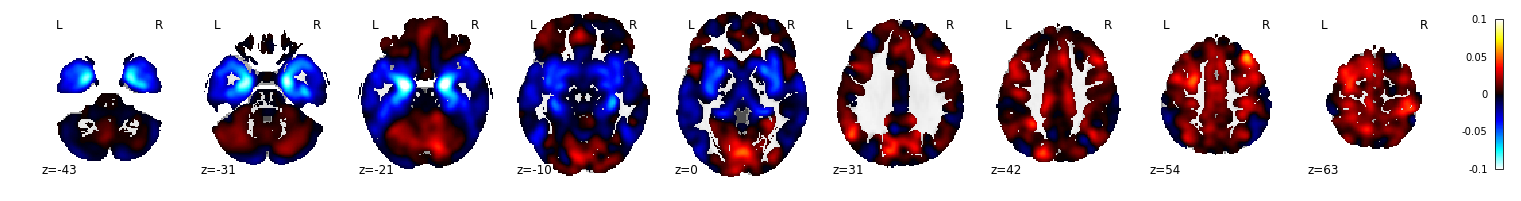

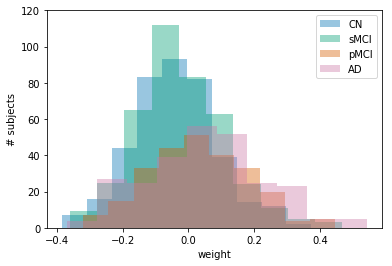

############################################################
GLM results for effect of diagnosis on subtype weight
############################################################


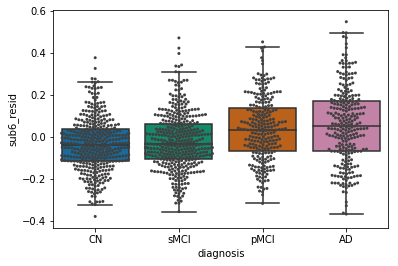

                            OLS Regression Results                            
Dep. Variable:                   sub6   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     14.70
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           1.56e-18
Time:                        20:10:31   Log-Likelihood:                 675.27
No. Observations:                1305   AIC:                            -1335.
Df Residuals:                    1297   BIC:                            -1293.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1618      0.084     -1.920      0.0

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


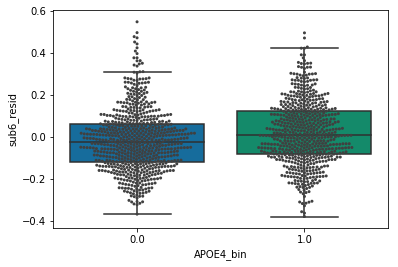

                            OLS Regression Results                            
Dep. Variable:                   sub6   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.685
Date:                Sun, 10 Dec 2017   Prob (F-statistic):            0.00258
Time:                        20:10:34   Log-Likelihood:                 634.63
No. Observations:                1305   AIC:                            -1257.
Df Residuals:                    1299   BIC:                            -1226.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0294      0.085     -0.345      0.7

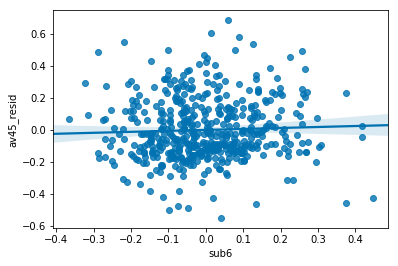

                            OLS Regression Results                            
Dep. Variable:                   AV45   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     25.47
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           6.29e-33
Time:                        20:10:35   Log-Likelihood:                 117.18
No. Observations:                 501   AIC:                            -216.4
Df Residuals:                     492   BIC:                            -178.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8409      0.209      4.022      0.0

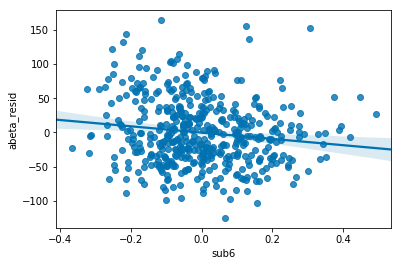

                            OLS Regression Results                            
Dep. Variable:                  ABETA   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     19.30
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           4.15e-25
Time:                        20:10:35   Log-Likelihood:                -2483.6
No. Observations:                 470   AIC:                             4985.
Df Residuals:                     461   BIC:                             5023.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    228.8076     44.876      5.099      0.0

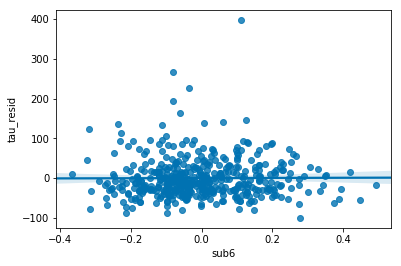

                            OLS Regression Results                            
Dep. Variable:                    TAU   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     12.58
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           2.46e-16
Time:                        20:10:36   Log-Likelihood:                -2440.4
No. Observations:                 457   AIC:                             4899.
Df Residuals:                     448   BIC:                             4936.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.9030     47.961      0.665      0.5

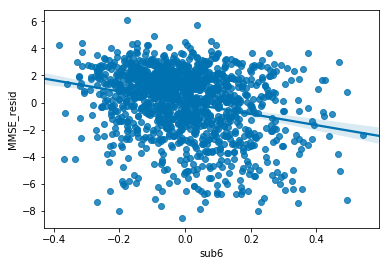

                            OLS Regression Results                            
Dep. Variable:                MMSE_bl   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     55.12
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           4.98e-52
Time:                        20:10:37   Log-Likelihood:                -3006.4
No. Observations:                1305   AIC:                             6025.
Df Residuals:                    1299   BIC:                             6056.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.7064      1.379     15.735      0.0

In [96]:
get_subtype_results(sub_img, 6, adni_df)

# subtype 7

Running analyses for subtype 7 ....


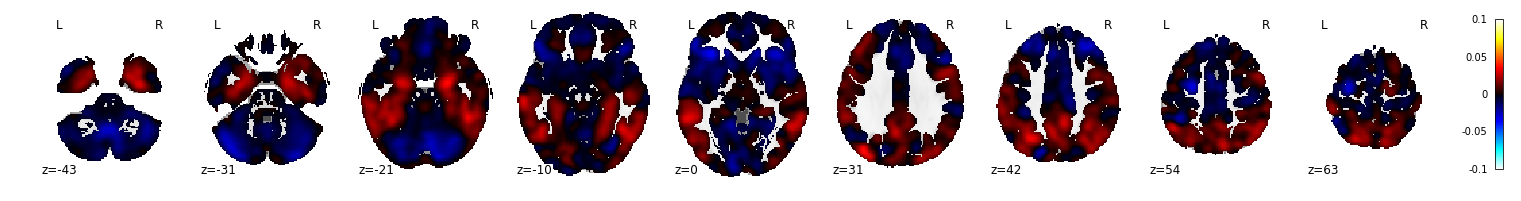

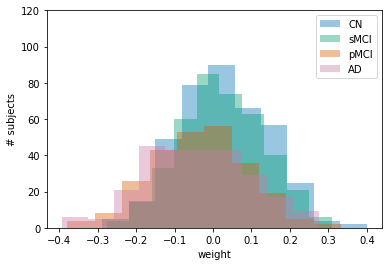

############################################################
GLM results for effect of diagnosis on subtype weight
############################################################


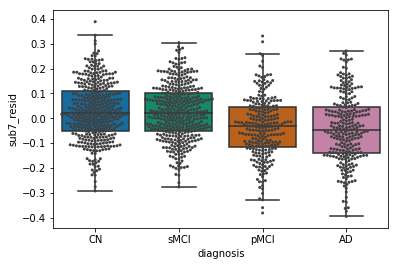

                            OLS Regression Results                            
Dep. Variable:                   sub7   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     15.98
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           3.04e-20
Time:                        20:10:44   Log-Likelihood:                 936.75
No. Observations:                1305   AIC:                            -1858.
Df Residuals:                    1297   BIC:                            -1816.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1836      0.069      2.662      0.0

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


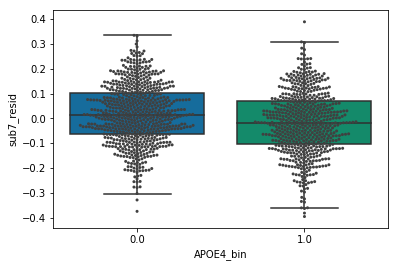

                            OLS Regression Results                            
Dep. Variable:                   sub7   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     5.773
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           2.80e-05
Time:                        20:10:47   Log-Likelihood:                 897.12
No. Observations:                1305   AIC:                            -1782.
Df Residuals:                    1299   BIC:                            -1751.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0859      0.070      1.231      0.2

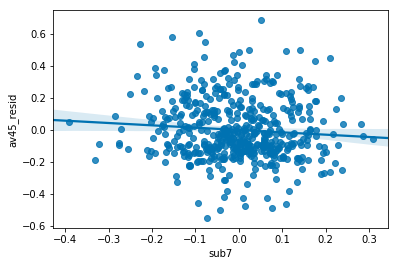

                            OLS Regression Results                            
Dep. Variable:                   AV45   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     25.96
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           1.66e-33
Time:                        20:10:48   Log-Likelihood:                 118.58
No. Observations:                 501   AIC:                            -219.2
Df Residuals:                     492   BIC:                            -181.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8597      0.209      4.122      0.0

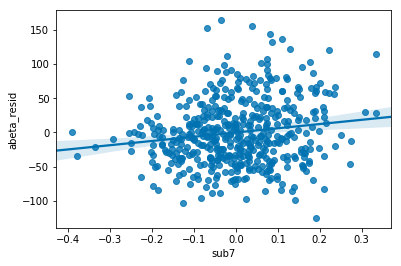

                            OLS Regression Results                            
Dep. Variable:                  ABETA   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     19.63
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           1.60e-25
Time:                        20:10:49   Log-Likelihood:                -2482.6
No. Observations:                 470   AIC:                             4983.
Df Residuals:                     461   BIC:                             5021.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    222.4884     44.846      4.961      0.0

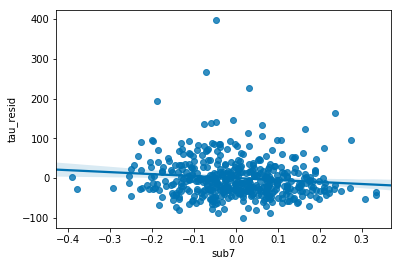

                            OLS Regression Results                            
Dep. Variable:                    TAU   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     13.58
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           1.15e-17
Time:                        20:10:50   Log-Likelihood:                -2437.1
No. Observations:                 457   AIC:                             4892.
Df Residuals:                     448   BIC:                             4929.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.6434     47.698      0.831      0.4

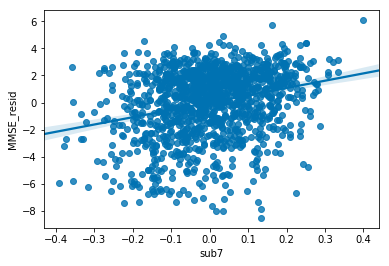

                            OLS Regression Results                            
Dep. Variable:                MMSE_bl   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     58.02
Date:                Sun, 10 Dec 2017   Prob (F-statistic):           1.35e-54
Time:                        20:10:51   Log-Likelihood:                -3000.4
No. Observations:                1305   AIC:                             6013.
Df Residuals:                    1299   BIC:                             6044.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.4208      1.373     15.598      0.0

In [97]:
get_subtype_results(sub_img, 7, adni_df)